# ============================================================

# Product Recommendation Engine - Innovate Bank

# ============================================================

# What is Collaborative filtering?

Collaborative filtering is commonly used for recommender systems. The aim is to fill in missing entries of a user-item association matrix, in our case, the customer-product rating matrix. MLlib currently supports model-based collaborative filtering, in which users and products are described by a small set of latent factors that can be used to predict missing entries. Thus, we will implement the alternating least squares (ALS) algorithm to learn these latent factors.

# Model Stages
1. Import Packages and Load Data
2. Data Exploration
3. Train and Test Validation - Parameter Tuning
4. Finalize Alternating Least Squares Recommendation Model
5. Publish and Execute Model

# 1. Import Packages and Load Data 


In [13]:
# upload packages
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt

# machine learning packages
from pyspark.sql import Row
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALSModel, ALS
from pyspark.ml.feature import SQLTransformer


In [14]:
# import data from hdfs - Select the product, customer and rating
Customer_Accounts = spark.sql("select customer_urn, productid,products, rating from recommendisa.accounts_training_data")


In [15]:
# change datatype for customer urn (integer), productid (integer) and rating (float) - this is the required input for ALS
Customer_Accounts = Customer_Accounts.withColumn('customer_urn', col('customer_urn').cast(IntegerType()))
Customer_Accounts = Customer_Accounts.withColumn('productid', col('productid').cast(IntegerType()))
Customer_Accounts = Customer_Accounts.withColumn('rating', col('rating').cast(FloatType()))

In [16]:
# Remove rows that have missing values or no customer urns
Customer_Accounts = Customer_Accounts.na.drop(subset=["customer_urn"])
print "There are ", format(Customer_Accounts.count(),',d'), " customer records in the Accounts Table"

There are  2,095,562  customer records in the Accounts Table


# 2. Data Exploration - Investment Accounts

In [17]:
#convert to pandas dataframe for plotting
all_accounts = Customer_Accounts.toPandas()

In [18]:
#select all investment products
investment_accounts = all_accounts.loc[(all_accounts['products']  == 'Investment ISAs') | 
                                       (all_accounts['products']  == 'Mutual Funds') | 
                                       (all_accounts['products']  == 'Structured Products')|
                                       (all_accounts['products']  == 'Stocks')|
                                       (all_accounts['products']  == 'Government Bonds')|
                                       (all_accounts['products']  == 'Secured Lending')|
                                       (all_accounts['products']  == 'Corporate Bonds')|
                                       (all_accounts['products']  == 'ETFs'),]

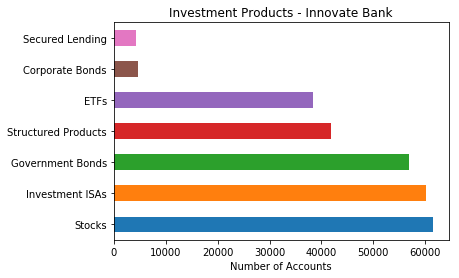

In [19]:
#barplot for # of investment products
investment_accounts['products'].value_counts().plot(kind = 'barh')
plt.xlabel('Number of Accounts')
plt.title('Investment Products - Innovate Bank')
plt.show()

# 3. Train and test validation


ALS algorithm has training parameters such as rank for matrix factors and regularization constants. To determine a good combination of the training parameters, we will evaluate rmse for each set of parameters. We will train the model on 80% of the data, and then use the trained algorithm to make predictions on the remaining test set (20%). Next, we will compare the predicted rating with the actual rating in the testset and calculate RMSE. RMSE represents the sample standard deviation of the differences between the predicted values with the actual values. 

# 4. Finalize Recommendation Model (Implicit Feedback)

# Algorithm: Alternating Least Squares

In [20]:
# Save the parameters that provide the lowers error rate into variables below (rank and maxiter paramters only) 
Best_rank = 4 
Best_iteration = 5

In [21]:
# Set the parameters for the final als model
als = ALS(maxIter= Best_iteration ,rank = Best_rank, implicitPrefs=True, userCol="customer_urn", itemCol="productid", ratingCol="rating", nonnegative = True)

# train als model with above paramters on accounts dataset
cf_model = als.fit(Customer_Accounts)

In [22]:
# pipeline to save the als recommendation algorithm 
# this allows us to predict ratings for missing entires of customer and product tuples
pipeline = Pipeline(stages=[cf_model])

In [23]:
# fit pipeline on the customer accounts data
model = pipeline.fit(Customer_Accounts)

# 5. Publish and Execute Final Model

In [24]:
# save to hdfs and publish model to BDA
# in order to execute the model in BDA, it requires customerurn and productid fields as integer
model.write().overwrite().save("hdfs://ussm-mag-ambari01.lab.opentext.com/OpenText/models/Financial_Recommender")

# ===========================================================

# Done!